Import Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
import cv2
from PIL import Image
import warnings
import tensorflow as tf
import random
warnings.filterwarnings("ignore")

Preprocessing The sampled Dtataset

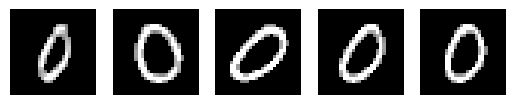

In [ ]:
# Function to reduce blur with Gaussian blur reduction
def reduce_blur(image):
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)
    return blurred_image

# Function to gently sharpen the image
def gentle_sharpen(image):
    sharpening_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image_8bit = np.uint8(image * 255)
    sharpened_image = cv2.filter2D(image_8bit, -1, sharpening_kernel)
    return sharpened_image / 255.0

# Function to enhance contrast
def enhance_contrast(img):
    img_8bit = np.uint8(img * 255)
    equalized_img = cv2.equalizeHist(img_8bit)
    return equalized_img / 255.0

# Function to apply soft thresholding
def soft_threshold(image, threshold=0.5):
    thresholded_image = np.where(image < threshold, 0, image)
    return thresholded_image

# Load and process image
def load_image(img_path, img_size=(28, 28)):
    try:
        img = Image.open(img_path).convert("L").resize(img_size)
        img = np.array(img) / 255.0
        img = reduce_blur(img)
        img = gentle_sharpen(img)
        img = enhance_contrast(img)
        img = soft_threshold(img, threshold=0.5)
        return img
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return np.zeros((img_size[0], img_size[1]))

# Load dataset
data = pd.read_csv("synthetic_mnist_dataset/labels.csv")
data.columns = ['img_path', 'label']

# Process images and labels
X = np.array([load_image(path) for path in data['img_path']])
y = np.array(data['label'])

# Visualize processed images
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i + 1000], cmap='gray')
    plt.axis('off')
plt.show()

# Create unique DataFrame for images and labels, removing duplicates
df = pd.DataFrame(X.reshape(X.shape[0], -1))
df['label'] = y
df_unique = df.drop_duplicates()

# Split unique dataset into features and labels
X_unique = df_unique.iloc[:, :-1].to_numpy()
y_unique = df_unique.iloc[:, -1].to_numpy()

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_unique, y_unique, test_size=0.3, random_state=42)
X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape data for Decision Tree model
x_train_flattened = X_train.reshape(X_train.shape[0], -1)
x_validate_flattened = X_validate.reshape(X_validate.shape[0], -1)
x_test_flattened = X_test.reshape(X_test.shape[0], -1)


Train the Decisition Tree

In [3]:
# Initialize and train Decision Tree model
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=4)
dt_classifier.fit(x_train_flattened, y_train)

# Validate and evaluate model
y_validate_pred = dt_classifier.predict(x_validate_flattened)
validate_accuracy = accuracy_score(y_validate, y_validate_pred)
print(f"Validation Accuracy: {validate_accuracy:.4f}")

y_test_pred = dt_classifier.predict(x_test_flattened)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Display classification report
target_names = [f"Class {i}" for i in range(10)]
print(classification_report(y_test, y_test_pred, target_names=target_names, zero_division=1))



Validation Accuracy: 0.7128
Test Accuracy: 0.6996
              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.99      1028
     Class 1       0.90      1.00      0.95      1053
     Class 2       0.54      0.92      0.68      1049
     Class 3       0.97      0.97      0.97      1017
     Class 4       0.78      0.02      0.04      1087
     Class 5       0.98      0.92      0.95      1119
     Class 6       1.00      0.22      0.36      1073
     Class 7       0.66      0.10      0.17      1054
     Class 8       0.99      0.93      0.96      1010
     Class 9       0.32      0.99      0.49      1011

    accuracy                           0.70     10501
   macro avg       0.81      0.71      0.66     10501
weighted avg       0.82      0.70      0.65     10501



Visualize the Decition tree

In [4]:
# Plot Decision Tree
plt.figure(figsize=(110, 10), dpi=300)
plot_tree(dt_classifier, filled=True, rounded=True, class_names=target_names, fontsize=10)

# Save the plot 
plt.savefig("Decision_Tree.png", format="png", bbox_inches="tight") 
plt.show()
